# Activity Recognition

Dataset used:
[Wireless Sensor Data Mining (WISDM) Lab](http://www.cis.fordham.edu/wisdm/).

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
# from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

# rcParams['figure.figsize'] = 14, 8

CLASSES = 4
RANDOM_SEED = 42
L2_LOSS = 0.001
LEARNING_RATE = 0.005

c:\users\patrycja\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Defining the dataset
We don't want to predict upstairs/downstairs walking so we will not take these activities into account.

In [2]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()
df = df[df.activity != 'Upstairs']
df = df[df.activity != 'Downstairs']

In [3]:
drop_n = int(len(df) * 0.8)

drop_indices = np.random.choice(df.index, drop_n, replace=False)
df_small = df.drop(drop_indices)

## Overview of dataset
First rows from dataset

In [4]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Random 10 rows from dataset

In [5]:
df_10 = df.sample(n=10)
print(df_10)

         user activity        timestamp  x-axis  y-axis     z-axis
641112     12  Sitting   18720091500000    8.20   -2.14   3.910000
191109     27  Walking   10451282239000    6.13   15.36  -2.533385
955270      1  Walking    5743502362000   -8.24    0.23  -3.570000
167968      6  Jogging    2880122203000   -4.48    9.23  15.132206
999817      2  Jogging    8898112348000    2.07    1.61  -2.260000
923261     22  Walking     817202312000    8.81    7.89  -1.040000
169514      6  Jogging    2956912242000   19.57    9.62   2.152015
342746     11  Walking    1753622325000   -1.57   13.80   1.116869
1086499    19  Walking  130755181490000   -1.76    4.37  -0.340000
333182     35  Jogging    1294922252000   -3.30   -8.50  -4.140586


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874907 entries, 0 to 1098203
Data columns (total 6 columns):
user         874907 non-null int64
activity     874907 non-null object
timestamp    874907 non-null int64
x-axis       874907 non-null float64
y-axis       874907 non-null float64
z-axis       874907 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 86.7+ MB


## Exploration & Analysis

We will be most interested in columns: activity, x-axis, y-axis and z-axis.

Number of training examples by user

In [7]:
df['user'].value_counts().plot(kind='bar', title='Number of training examples by user')

Number of training examples by activity

In [8]:
df['activity'].value_counts().plot(kind='barh', title='Number of training examples by activity')

In [9]:
def plot_activity(df, activity):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)

Axes for sitting activity

In [10]:
plot_activity(df, "Sitting")

Axes for standing activity

In [11]:
plot_activity(df, "Standing")

Axes for walking activity

In [12]:
plot_activity(df, "Walking")

Axes for jogging activity

In [13]:
plot_activity(df, "Jogging")

## Data preprocessing

In [14]:
TIME_STEPS = 200
FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + TIME_STEPS]
    ys = df['y-axis'].values[i: i + TIME_STEPS]
    zs = df['z-axis'].values[i: i + TIME_STEPS]
    label = stats.mode(df['activity'][i: i + TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

c:\users\patrycja\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [15]:
np.array(segments).shape

(43736, 3, 200)

In [16]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_STEPS, FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [17]:
reshaped_segments.shape

(43736, 200, 3)

In [18]:
labels[0]

array([1., 0., 0., 0.], dtype=float32)

## Training and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
print(len(X_train))
print(len(y_train))
print(X_train.shape)
print(X_train[1][1:10])

34988
34988
(34988, 200, 3)
[[  6.21   7.35   5.18]
 [  5.86   0.34  -4.37]
 [-16.32 -12.72  -0.19]
 [  8.2   13.02   5.63]
 [  7.35   5.09  -1.99]
 [ -4.33   8.35   6.13]
 [  4.14   2.41  -5.41]
 [-10.12 -16.59  -6.93]
 [  0.57  12.87  11.33]]


In [21]:
len(X_test)

8748

## The model

We will use LSTM network (“LSTMs” – are a special kind of RNN, capable of learning long-term dependencies) to build our model with 2 fully connected layers. Number of classification classes is 4: sitting, standing, walking and jogging.

In [22]:
HIDDEN_UNITS = 64

In [23]:
def create_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([FEATURES, HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([HIDDEN_UNITS, CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, TIME_STEPS, 0)

    layers = [tf.contrib.rnn.BasicLSTMCell(HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    layers = tf.contrib.rnn.MultiRNNCell(layers)

    outputs, _ = tf.contrib.rnn.static_rnn(layers, hidden, dtype=tf.float32)

    last_output = outputs[-1]

    return tf.matmul(last_output, W['output']) + biases['output']

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, TIME_STEPS, FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, CLASSES])

In [25]:
W = {
    'hidden': tf.Variable(tf.random_normal([FEATURES, HIDDEN_UNITS])),
    'output': tf.Variable(tf.random_normal([HIDDEN_UNITS, CLASSES]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([HIDDEN_UNITS], mean=1.0)),
    'output': tf.Variable(tf.random_normal([CLASSES]))
}

inputs = tf.transpose(X, [1, 0, 2])
inputs = tf.reshape(inputs, [-1, FEATURES])
hidden = tf.nn.relu(tf.matmul(inputs, W['hidden']) + biases['hidden'])
hidden = tf.split(hidden, TIME_STEPS, 0)

layers = [tf.contrib.rnn.BasicLSTMCell(HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
layers = tf.contrib.rnn.MultiRNNCell(layers)

outputs, _ = tf.contrib.rnn.static_rnn(layers, hidden, dtype=tf.float32)

last_output = outputs[-1]

pred_Y = tf.matmul(last_output, W['output']) + biases['output']

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [26]:
l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

## Training
The proper training phase.

In [28]:
EPOCHS = 50
BATCH_SIZE = 1024

saver = tf.train.Saver()

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, train_acc, train_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, test_acc, test_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})
    
    history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    print(f'epoch: {i} test accuracy: {test_acc} loss: {test_loss}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8539094924926758 loss: 0.7899917364120483


epoch: 2 test accuracy: 0.9459304809570312 loss: 0.5844630002975464


epoch: 3 test accuracy: 0.9652491807937622 loss: 0.49394869804382324


epoch: 4 test accuracy: 0.9767947196960449 loss: 0.4406609535217285


epoch: 5 test accuracy: 0.9754229784011841 loss: 0.4243931174278259


epoch: 6 test accuracy: 0.9727937579154968 loss: 0.40795254707336426


epoch: 7 test accuracy: 0.9761088490486145 loss: 0.38454771041870117


epoch: 8 test accuracy: 0.9789665937423706 loss: 0.3666485548019409


epoch: 9 test accuracy: 0.9845678806304932 loss: 0.3281221091747284


epoch: 10 test accuracy: 0.9793095588684082 loss: 0.32508179545402527


epoch: 11 test accuracy: 0.9735939502716064 loss: 0.33062979578971863


epoch: 12 test accuracy: 0.980681300163269 loss: 0.3131677508354187


epoch: 13 test accuracy: 0.9774805903434753 loss: 0.30051448941230774


epoch: 14 test accuracy: 0.9259259104728699 loss: 0.38435643911361694


epoch: 15 test accuracy: 0.9650205969810486 loss: 0.3653830885887146


epoch: 16 test accuracy: 0.9815958142280579 loss: 0.2872661352157593


epoch: 17 test accuracy: 0.9837677478790283 loss: 0.26303961873054504


epoch: 18 test accuracy: 0.9842249751091003 loss: 0.2422497272491455


epoch: 19 test accuracy: 0.9839963316917419 loss: 0.2398146390914917


epoch: 20 test accuracy: 0.9843392968177795 loss: 0.2339652180671692


epoch: 21 test accuracy: 0.9829675555229187 loss: 0.22545644640922546


epoch: 22 test accuracy: 0.9853680729866028 loss: 0.21462883055210114


epoch: 23 test accuracy: 0.9858253598213196 loss: 0.2056870460510254


epoch: 24 test accuracy: 0.9884545207023621 loss: 0.18680907785892487


epoch: 25 test accuracy: 0.9895976185798645 loss: 0.1771658957004547


epoch: 26 test accuracy: 0.9829675555229187 loss: 0.1904827207326889


epoch: 27 test accuracy: 0.9902834892272949 loss: 0.16925977170467377


epoch: 28 test accuracy: 0.992226779460907 loss: 0.15741848945617676


epoch: 29 test accuracy: 0.9907407164573669 loss: 0.16066962480545044


epoch: 30 test accuracy: 0.9913123250007629 loss: 0.14999622106552124


epoch: 31 test accuracy: 0.9884545207023621 loss: 0.16032688319683075


epoch: 32 test accuracy: 0.9793095588684082 loss: 0.202198326587677


epoch: 33 test accuracy: 0.9852537512779236 loss: 0.16508615016937256


epoch: 34 test accuracy: 0.9881115555763245 loss: 0.15915699303150177


epoch: 35 test accuracy: 0.9909693598747253 loss: 0.14608445763587952


epoch: 36 test accuracy: 0.9925697445869446 loss: 0.1369749903678894


epoch: 37 test accuracy: 0.993712842464447 loss: 0.1259295791387558


epoch: 38 test accuracy: 0.9935985207557678 loss: 0.12195050716400146


epoch: 39 test accuracy: 0.9897119402885437 loss: 0.14024856686592102


epoch: 40 test accuracy: 0.9884545207023621 loss: 0.13695453107357025


epoch: 41 test accuracy: 0.9911980032920837 loss: 0.1263553500175476


epoch: 42 test accuracy: 0.9927983283996582 loss: 0.11785312741994858


epoch: 43 test accuracy: 0.9929126501083374 loss: 0.11690191179513931


epoch: 44 test accuracy: 0.9934841990470886 loss: 0.10914775729179382


epoch: 45 test accuracy: 0.9913123250007629 loss: 0.1142624020576477


epoch: 46 test accuracy: 0.9934841990470886 loss: 0.10967054963111877


epoch: 47 test accuracy: 0.9827389121055603 loss: 0.1390596628189087


epoch: 48 test accuracy: 0.9934841990470886 loss: 0.11352158337831497


epoch: 49 test accuracy: 0.9892547130584717 loss: 0.1192886158823967


epoch: 50 test accuracy: 0.9919981956481934 loss: 0.10629428923130035



final results: accuracy: 0.9919981956481934 loss: 0.10629428923130035


Saving predictions and training history to a file.

In [32]:
pickle.dump(predictions, open("pickle/predictions.p", "wb"))
pickle.dump(history, open("pickle/history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

ERROR! Session/line number was not unique in database. History logging moved to new session 21


Loading files to variables.

In [33]:
history = pickle.load(open("pickle/history.p", "rb"))
predictions = pickle.load(open("pickle/predictions.p", "rb"))

ERROR! Session/line number was not unique in database. History logging moved to new session 22


## Evaluation

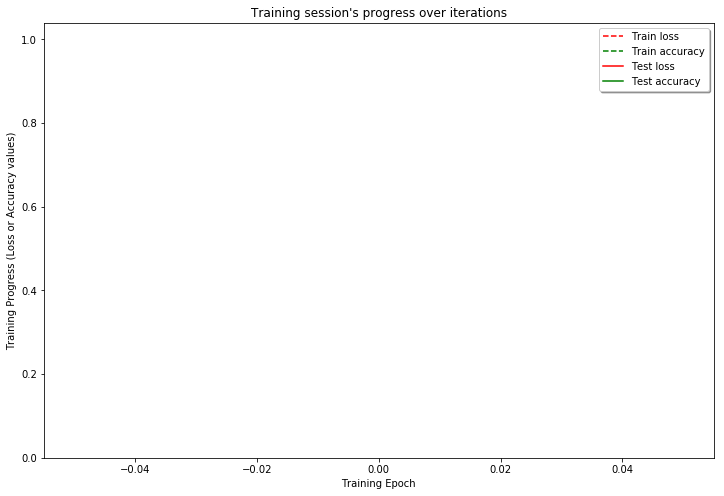

In [34]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [35]:
LABELS = ['Jogging', 'Sitting', 'Standing', 'Walking']

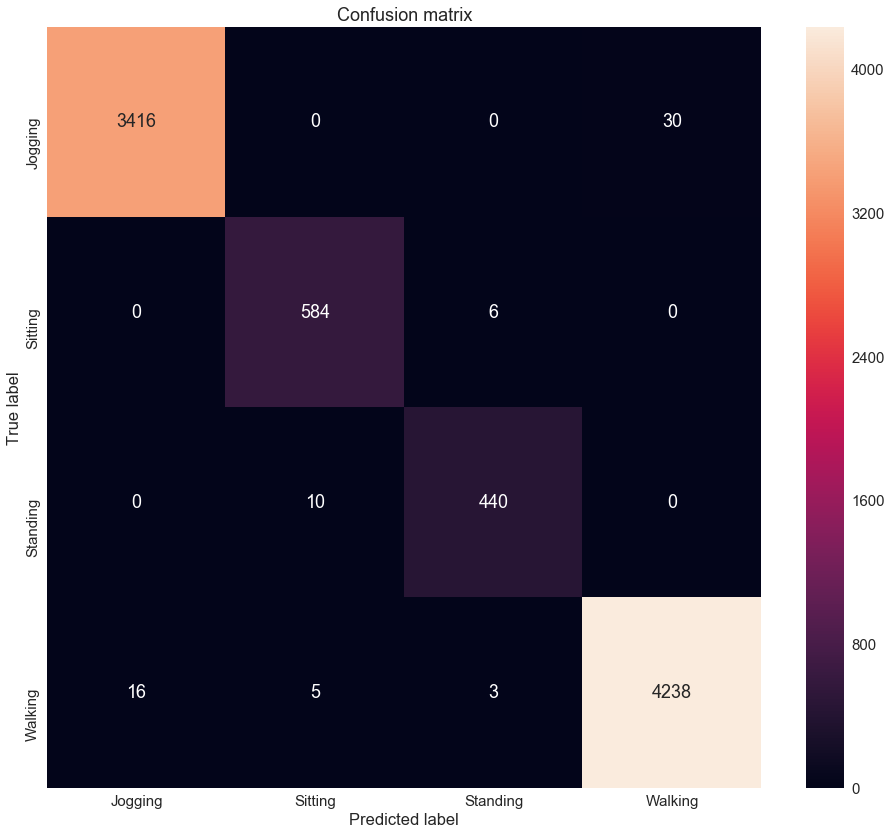

In [36]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Export the model

In [ ]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'models/frozen_'+MODEL_NAME+'_4.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Input graph file 'checkpoint/har.pbtxt' does not exist!


ERROR! Session/line number was not unique in database. History logging moved to new session 24
